## Setup

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy.sparse.linalg import cg

sns.set()

## Problem 2

We consider a sparse $500\times 500$ matrix $\mathbf{A}$ built with the following process:

- 1 in each diagonal entry
- Each off diagonal entry $\sim U(-1,1)$
- Replace each off diagonal entry with $|a_{ij}| > \tau$ by 0
- $\tau = $ 0.01, 0.05, 0.1, 0.2

This results in four matrices $\mathbf{A}_k$, one for each value of $\tau$. We then consider the right hand side to be $\mathbf{b}\sim U(-1,1)$.

In [90]:
A = [] #List of our constructed matrices
tau = [0.01, 0.05, 0.1, 0.2]

np.random.seed(0)

for k in range(len(tau)):
    #Create a diagonal matrix first
    mat = np.diag(np.ones(500))
    
    for i in range(mat.shape[0]):
        #Only look at upper diagonal and then mirror
        for j in range(i+1, mat.shape[1]):
            #Draw a unifrom
            u = np.random.uniform(-1,1)
            
            #Check size
            if np.abs(u) > tau[k]:
                u = 0
            
            #Maintain symmetry
            mat[i,j] = u
            mat[j,i] = u
                
    A.append(mat)

#Make the RHS a standard normal
b = np.random.uniform(-1, 1, size=500).reshape((500,1))

#Make sure all the A's are symmetric
for i, mat in enumerate(A):
    if not (mat.T == mat).all():
        print('Error, matrix %s not symmetric' % i)

#Just check the dimensions to be safe
print(len(A))
print(A[0].shape)
print(b.shape)

4
(500, 500)
(500, 1)


### a).
Here we can see the algorithms for Steepest Descent and Conjugate Gradient.

In [91]:
'''
Steepest Descent Algorithm:
Input:
    A: Coefficient matrix
    b: Result vector
    x: Initial solution guess
    tol: Residual error tolerance
    maxI: Maximum allowed iterations
    norm: Norm type for tolerance
    
Output:
    Success: Solution (x) and sequence of residuals (r_seq)
    Failure: Print error message, but return same data
'''
def steep(A, b, x, tol=1E-6, maxI=500, norm=np.inf, resnorm=2, iterates=False):
    
    r_seq = [] #Sequence of residual norms
    
    if iterates:
        iter_seq = [x]
    
    #Calculate initial residual
    r = b - A@x
    r_norm = np.linalg.norm(r, ord=resnorm)
    r_seq.append(r_norm)
    
    #Iterate
    for i in range(maxI):
        if r_norm<tol:
            if iterates:
                return x, r_seq, i, iter_seq
            return x, r_seq, i
        
        alpha = (r.T@r)/(r.T@A@r) #Calculate alpha for this iteration

        x = x + alpha*r #Update solution
        
        if iterates:
            iter_seq.append(x)

        r = b - A@x #Update residual
        r_norm = np.linalg.norm(r, ord=resnorm)
        r_seq.append(r_norm)
        
    print('Maximum iterations exceeded without achieving tolerance.')
    if iterates:
        return x, r_seq, i, iter_seq
    return x, r_seq, i

'''
Conjugate Gradient Algorithm:
Input:
    A: Coefficient matrix
    b: Result vector
    x: Initial solution guess
    tol: Residual error tolerance
    maxI: Maximum allowed iterations
    norm: Norm type for tolerance
    
Output:
    Success: Solution (x) and sequence of residuals (r_seq)
    Failure: Print error message, but return same data
'''
def conjGrad(A, b, x, tol=1E-6, maxI=500, norm=np.inf, resnorm=2):
    
    r_seq = [] #Sequence of residuals
    
    r0 = b - A@x #Initial residual
    r_norm = np.linalg.norm(r0, ord=resnorm)
    r_seq.append(r_norm)
    
    p = r0 #Initial conjugate vector
    
    for i in range(maxI):   
        if r_norm<tol:
            return x, r_seq, i
        
        alpha = (r0.T@r0)/(p.T@A@p)
        
        x = x + alpha*p #Update solution
        
        r = r0 - alpha*A@p #Update residual
        
        beta = (r.T@r)/(r0.T@r0)
        
        p = r + beta*p #Update conjugate vector
        
        #No longer need old residual
        r0 = r
        r_norm = np.linalg.norm(r0, ord=resnorm)
        r_seq.append(r_norm)
        
    print('Maximum iterations exceeded without achieving tolerance.')
    return x, r_seq, i

### b).
We apply Steepest Descent to solve each of the linear systems $\mathbf{A}_k\mathbf{x}=\mathbf{B}$

In [92]:
R = []
steep_i = []
I = []

#Solve each linear system
for i, mat in enumerate(A):
    print('Matrix %s' % i)
    _, r_seq, iters, iter_seq = steep(mat, b, np.zeros((500,1)), iterates=True)
    
    R.append(r_seq) #List of sequences of residuals
    steep_i.append(iters)
    I.append(iter_seq)

Matrix 0
Matrix 1
Matrix 2
Matrix 3
Maximum iterations exceeded without achieving tolerance.


/home/rs-coop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in matmul
/home/rs-coop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


We can see that the fourth linear system with $\tau=0.2$ is having problems. Specifically, it seems to exceed the maximum number of iterations and encounter some numerical issues.

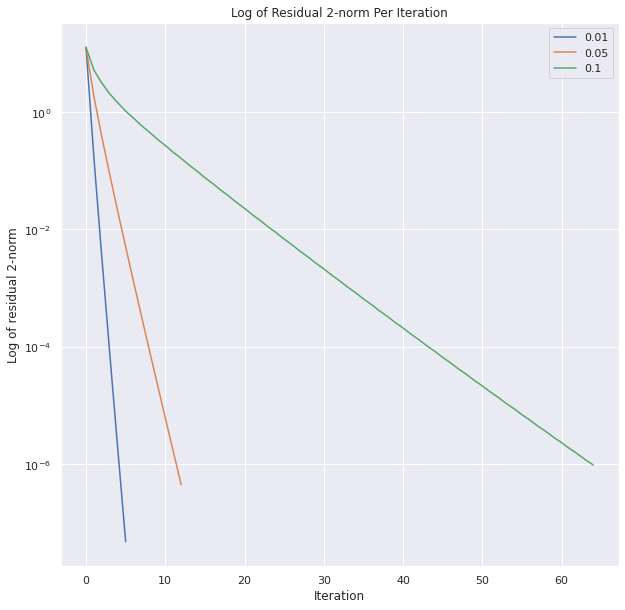

In [93]:
fig1, ax1 = plt.subplots(1,1,figsize=(10,10))

for i, norm_seq in enumerate(R):
    if i < 3:
        ax1.semilogy(norm_seq)
    
ax1.set_title('Log of Residual 2-norm Per Iteration')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log of residual 2-norm')
ax1.legend(tau);

### c).
We apply Conjugate Gradient to solve each of the linear systems $\mathbf{A}_k\mathbf{x}=\mathbf{B}$

In [94]:
R = []
conj_i = []

#Solve each linear system
for i, mat in enumerate(A):
    print('Matrix %s' % i)
    _, r_seq, iters = conjGrad(mat, b, np.zeros((500,1)))

    R.append(r_seq) #List of sequences of residuals
    conj_i.append(iters)

Matrix 0
Matrix 1
Matrix 2
Matrix 3
Maximum iterations exceeded without achieving tolerance.


Again we can see that our fourth linear system where $\tau=0.2$ has failed to converge.

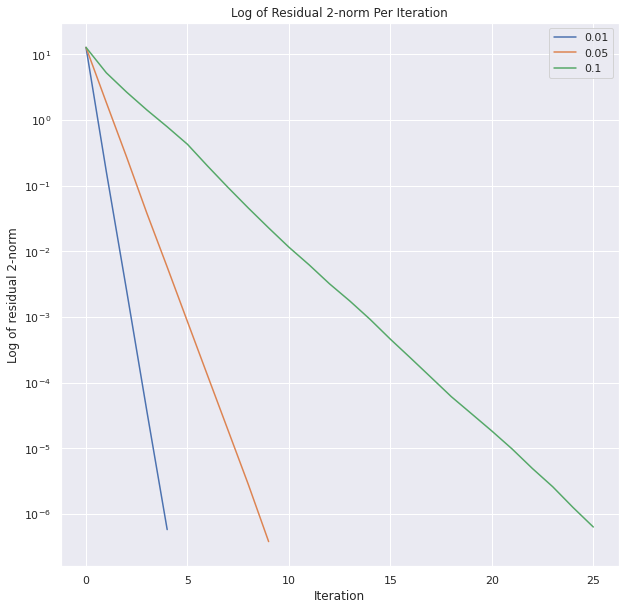

In [95]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

for i,norm_seq in enumerate(R):
    if i < 3:
        ax2.semilogy(norm_seq)
    
ax2.set_title('Log of Residual 2-norm Per Iteration')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Log of residual 2-norm')
ax2.legend(tau);

### d).
In the preceeding two figures we see that a solution has been converged to for the linear systems corresponding to $\tau=0.01, 0.05, 0.1$. However, both steepest descent and conjugate gradient fail to converge on the linear system where $\tau=0.2$. Ignoring this for a moment we see that in all of the other linear systems, the conjugate gradient algorithm is systematically faster -- which is expected. Furthermore, we see that with both algorithms we see that smaller $\tau$ results in faster convergence.

We are interested why $\tau=0.2$ fails to converge. We know that the algorithms will succeed when the matrix is SPD, so we will examine the eigenvalues of our matrices $\mathbf{A}_k$.

In [96]:
#Looking at eigenvalues of A_k
for i, mat in enumerate(A):
    evals, _ = np.linalg.eig(mat)
    
    if (evals <= 0).any():
        print('Non-positive eigenvalues in matrix %s with tau=%.1f' %(i+1, tau[i])) 

Non-positive eigenvalues in matrix 4 with tau=0.2


Ah-ha! We can see that the fourth matrix with the largest $\tau$ ($\tau=2$) has non-positive eigenvalues. This indicates that the matrix is not positive-definite, and thus we wont have convergence. The other matrices are SPD and that is why we get convergence.

### e).
We have the following error bound for the steepest descent algorithm:

$$ ||\mathbf{x}_{k}-\mathbf{x}_*||_A\leq\frac{\lambda_{max}-\lambda_{min}}{\lambda_{max}+\lambda_{min}}||\mathbf{x}_{k-1}-\mathbf{x}_*||_A $$

For the conjugate gradient algorithm we have the following error bound:

$$ ||\mathbf{x}_{k}-\mathbf{x}_*||_A\leq 2\Bigg(\frac{1-\sqrt{\kappa(A)^{-1}}}{1+\sqrt{\kappa(A)^{-1}}}\Bigg)^n||\mathbf{x}_*||_A $$

Where $\mathbf{x}_*$ is the solution of the linear system and $\kappa(A)$ is the condition number.

In [97]:
solutions = [cg(mat, b)[0] for mat in A[:-1]] #Solutions to the first three linear systems

def steepBound(A, x_prev, sol):
    evals, _ = np.linalg.eig(A)
    l_max = max(evals)
    l_min = min(evals)
    
    z = x_prev - sol
    
    return ((l_max-l_min)/(l_max+l_min))*(z.T@A@z)

def conjBound(A, sol, n):
    k = 1/np.linalg.cond(A)
    
    return (sol.T@A@sol)*2*((1-np.sqrt(k))/(1+np.sqrt(k)))**n

In [98]:
for i, mat in enumerate(A[:-1]):
    sol = solutions[i].reshape((500,1))
    er = steepBound(mat, I[i][-2], sol)
    v = I[i][-1] - sol
    res = v.T@mat@v
    
    print('Bound: %.10f, Actual: %.10f' % (er, res))

Bound: 0.0000000000, Actual: 0.0000000013
Bound: 0.0000000048, Actual: 0.0000000166
Bound: 0.0000000203, Actual: 0.0000000249


In the above output can see for the first three matrices where we have convergence, that the bound estimate is quite close to the actual residual norm. We note that the bound estimate is always smaller, but not by much. The two quantities are not the same, so we would not expect an exact match, but a relatively close one is validating.

In [99]:
conj_bound = [conjBound(A[i], solutions[i], np.arange(conj_i[i]+1)) for i in range(len(A)-1)]

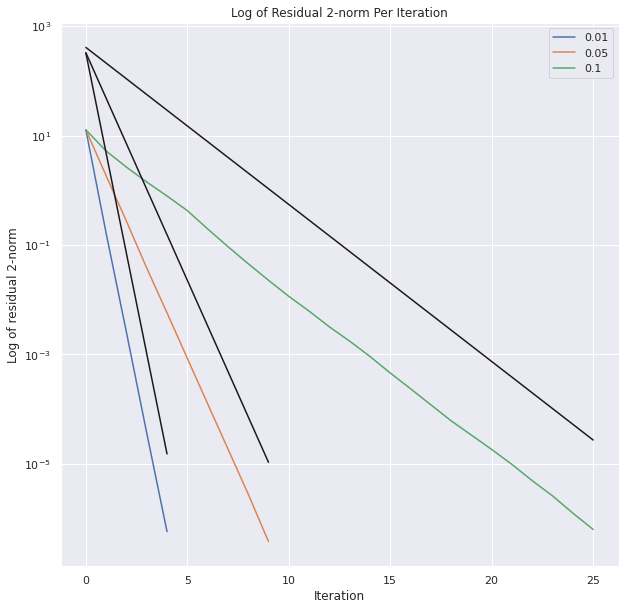

In [100]:
for i in range(len(A)-1):
#     ax1.semilogy(steep_bound[i], c='k')
    ax2.semilogy(conj_bound[i], c='k')
    
fig2

We see the same plot as for part c, but with three extra black lines. These lines correspond to the error bound for conjugate gradient. We can see that the associated norm of the residual is less than the error bound and follows a similar trajectory. Again it is not the same quantity, but it is validating to see a similar trend.

## Problem 4

We consider solving the system of non-linear equations:

$$ f_1(x,y) = 3x^2+4y^2-1 = 0 \:\:\:\: f_2(x,y) = y^3-8x^3-1 = 0 $$

Where we are looking for a solution $\mathbf{\alpha}$ near $(x,y)=(-0.5,0.25)$.

### a).
We apply fixed point iteration with the following matrix formulation.

$$
\mathbf{g}(\mathbf{x}) = \mathbf{x} -
\begin{bmatrix}
    0.016 & -0.17\\
    0.52 &-0.26
\end{bmatrix}
\begin{bmatrix}
    3x^2+4y^2-1\\
    y^3-8x^3-1
\end{bmatrix}
$$

In [101]:
'''
Fixed Point Iteration:
Input:
    g: Vector of iteration functions
    x0: Initial solution guess
    tol: Residual error tolerance
    maxI: Maximum allowed iterations
    norm: Norm type for tolerance
    
Output:
    Success: Solution (x) and number of iterations (i)
    Failure: ValueError for exceeding maximum iterations
'''
def FPI(g, x0, tol=1E-6, maxI=1000, norm=np.inf):
    
    x = np.zeros(x0.shape) #New iterate
    
    for i in range(1, maxI+1):
        x = g(x0) #Evaluate new iterate
        
        #Check if change is below tolerance
        if np.linalg.norm(x-x0, ord=norm)/np.linalg.norm(x, ord=norm) < tol:
            return x, i
        
        x0 = x
        
    raise ValueError('Maximum number of iterations exceeded.')

In [102]:
#Coefficient matrix for our iteration function g
C = np.array([[0.016, -0.17],[0.52, -0.26]])

#Returns the functions evaluated at (x1,x2)=x
def F(x):
    x1, x2 = x
    return [3*x1**2 + 4*x2**2 - 1, x2**3 - 8*x1**3 - 1]

#Returns the g iteration function at a point (x1,x2)=x
def g(x):
    z = np.array(F(x))
    return x - C@z

In [103]:
guess = np.array([[-0.5], [0.25]])
alpha, i = FPI(g, guess, tol=1E-7)
alpha = alpha.reshape((2,))
print('Solution (x,y) in %s iterations:' % i)
print(alpha, '\n')
print('Functions evaluated at solution:')
print(F(alpha))

Solution (x,y) in 5 iterations:
[-0.4972512   0.25407859] 

Functions evaluated at solution:
[5.54330359392452e-10, 1.2558354356428936e-09]


We can see that we have found the root of our equations as...

$$ \boxed{(x,y)=(-0.4972512, 0.25407859)} $$

This is with 7-digits of accuracy and was achieved in $\boxed{5}$ iterations.

### b).
This is a good choice for $\mathbf{g}(\mathbf{x})$ because (as we will see below) the infinity norm of the Jacobian of our iteration function $\mathbf{g}(\mathbf{x})$ is strictly less than 1 at the root. The Jacobian is obtained by differentiating $\mathbf{g}$ with respect to $x$ and inserting that as the first column, and then differentiating with respect to $y$ and inserting that as the second column.

In [104]:
#Returns the Jacobian of the g function above at a point (x1,x2)=x
def Jacob(x):
    x1, x2 = x
    dx1 = np.array([1,0]).reshape((2,1)) - C@(np.array([6*x1,-24*x1**2]).reshape((2,1)))
    dx2 = np.array([0,1]).reshape((2,1)) - C@(np.array([8*x2,3*x2**2]).reshape((2,1)))
    
    return np.concatenate((dx1, dx2), axis=1)

In [105]:
J = Jacob(alpha)
norm = np.linalg.norm(J, np.inf)

print('Infinity norm of Jacobian at root: %f' % norm)

Infinity norm of Jacobian at root: 0.039322


We can clearly see that the this value is strictly less than 1. Thus we know that there is an open ball around the solution where any fixed point iteration will converge. This is what makes our choice for $\mathbf{g}(\mathbf{x})$ a good choice.